In [58]:
import linkerapp_fako_feb10 as linkerAPP     
import linkerappUtil as Util
import numpy as np
import mrcfile
import matplotlib.pyplot as plt
from IPython.display import clear_output

class x:
    def __init__(self, xname, helices, pos_range, ):
        self.xname = xname
        self.helices = helices
        self.pos_range = pos_range
        self.res_average = None
        self.res_stddev = None

def read_mrc(filename):
    with mrcfile.open(filename, mode='r') as mrc:
        data = mrc.data.transpose()
        m_o = np.array(mrc.header["origin"])
        m_origin = np.array([m_o["x"], m_o["y"], m_o["z"]])
        m_c = np.array(mrc.header["cella"])
        m_cell = np.array([m_c["x"], m_c["y"], m_c["z"]])
        m_grid = np.array([mrc.header["nx"], mrc.header["ny"], mrc.header["nz"]])
        m_spacing = m_cell/m_grid
        metadata = m_origin, m_cell, m_grid, m_spacing
        return data, metadata


def create_mask(map_data, threshold):
    mask = np.where(map_data > threshold, 1, 0)
    return mask

def mask_locres(locres, mask):
    masked = np.multiply(mask, locres)
    return masked

def locres_statistics(locres):
    flat = locres.flatten()
    zeroesremoved = flat[flat != 0]
    res_average = np.average(zeroesremoved)    
    res_stddev = np.std(zeroesremoved)
    return res_average, res_stddev

def x_over_res_statistic(xover_list, viewer, neighbors = 1,threshold = 0.088):
    class x:
        def __init__(self, xname, helices, pos_range, ):
            self.xname = xname
            self.helices = helices
            self.pos_range = pos_range
            self.res_average = None
            self.res_stddev = None
        
    xover_kisses = dict()
    xover_intra = dict()

    for item in xover_list:
        helix1 = item[0][0]
        helix2 = item[2][0]
        helices = [helix1, helix2]
        pos1 = item[0][1]
        pos2 = item[1][1]
        pos_range = range(pos1-neighbors, pos2+neighbors+1)
        if helix1 < 10:
            xover_name = "h00{}_p{}".format(helix1, pos1)
        elif 10 <= helix1 < 100:
            xover_name = "h0{}_p{}".format(helix1, pos1)
        else:
            xover_name = "h{}_p{}".format(helix1, pos1)
        
        if helix1%2 == 0:      #even-uneven -> scaffold kiss
            xover_kisses[xover_name] = x(xname = xover_name, helices = helices, pos_range = pos_range)
        else:      #even-uneven -> scaffold kiss
            xover_intra[xover_name] = x(xname = xover_name, helices = helices, pos_range = pos_range)
            
    N_kisses = len(xover_kisses)
    N_intra = len(xover_intra)
    
    print("processing crossover kisses")
    for i,(x_name, x) in enumerate(xover_kisses.items()):
        atoms_selection, color_dict = viewer.select_by_helixandbase(x.helices, x.pos_range)
        name_out = x_name
        xover_map = viewer.getmrc(atoms_selection, context=context, cut_box=False)
        xover_mask = create_mask(xover_map, threshold)
        xover_locres = mask_locres(locres_data, xover_mask)
        xover_kisses[x_name].res_average, xover_kisses[x_name].res_stddev = locres_statistics(xover_locres) 
        clear_output(wait=True)
        print(" {} of {} crossover kisses finished".format(i+1,N_kisses))
    
    print("processing intra crossovers")
    for i,(x_name, x) in enumerate(xover_intra.items()):
        atoms_selection, color_dict = viewer.select_by_helixandbase(x.helices, x.pos_range)
        name_out = x_name
        xover_map = viewer.getmrc(atoms_selection, context=context, cut_box=False)
        xover_mask = create_mask(xover_map, threshold)
        xover_locres = mask_locres(locres_data, xover_mask)
        xover_intra[x_name].res_average, xover_intra[x_name].res_stddev = locres_statistics(xover_locres)
        clear_output(wait=True)
        print("{} of {} intra crossovers finished".format(i+1,N_intra))
    
    clear_output(wait=True)
    res_kiss = []
    for (x_name, x) in xover_kisses.items():
        res_kiss.append(x.res_average)
    kiss_average = np.average(res_kiss)
    kiss_stddev = np.std(res_kiss)
    print("average resolution scaffold kisses: {:.2f}".format(kiss_average))
    print("stddev  resolution scaffold kisses: {:.2f}".format(kiss_stddev))

    res_intra = []
    for (x_name, x) in xover_intra.items():
        res_intra.append(x.res_average) 
    intra_average = np.average(res_intra)
    intra_stddev = np.std(res_intra)
    print("average resolution normal scaffold xover: {:.2f}".format(intra_average))
    print("stddev  resolution normal scaffold xover: {:.2f}".format(intra_stddev))
    
    return kiss_average, kiss_stddev, intra_average, intra_stddev



def z_resolution(helices, pos_range, neighbors = 0, threshold = 0.088):
    N_pos = len(pos_range)
    res = np.zeros((3,N_pos))

    for i, pos in enumerate(pos_range):
        res[0,i] = pos
        pos_range_i = range(pos-neighbors, pos+neighbors+1)
        atoms_selection, color_dict = viewer.select_by_helixandbase(helices, pos_range_i)
        xover_map = viewer.getmrc(atoms_selection, context=context, cut_box=False)
        xover_mask = create_mask(xover_map, threshold)
        xover_locres = mask_locres(locres_data, xover_mask)
        res[1,i], res[2,i] = locres_statistics(xover_locres)
        clear_output(wait=True)
        print("iteration {} of {} finished".format(i+1,N_pos))
        
    positions = res[0]
    averages = res[1]
    stddev = res[2]
    return positions, averages, stddev

def plot_res(axes, set_, color, show_kiss = False, linestyle = '-', marker = 'o', label = None, showlegend = True, show_axis = True):
    positions = set_.positions
    averages = set_.averages
    stddevs = set_.stddevs
    pos_kiss = set_.kiss_pos
    axes.plot(positions, averages, linestyle = linestyle, color = color, label = label)
    axes.fill_between(positions, averages-stddevs, averages+stddevs, alpha=0.25, color = color)
    axes.set_ylim((7,17))
    axes.set_xlim((20,180))
    if show_kiss:
        index_kiss = list(positions).index(pos_kiss)
        res_kiss = averages[index_kiss]
        axes.plot(pos_kiss,res_kiss, marker = marker ,color=color)
    if show_axis:
        axes.set_xlabel('base pair position')
        axes.set_ylabel('resolution[Å]')
    if showlegend:
        axes.legend(loc='lower right')
        
def plot_res_poscorr(axes, set_, color, show_kiss = False, linestyle = '-', marker = 'o', label = None, 
                     showlegend = True, show_axis = True, showtitle = True, plotleft = False, plotright=False,
                     xylabelsize = 18, xyticklabelsize = 16, lablesize = 20):
    positions = np.array([i for i in set_.positions]) - 30
    averages = set_.averages
    stddevs = set_.stddevs
    axes.plot(positions, averages, linestyle = linestyle, color = color, label = label)
    axes.fill_between(positions, averages-stddevs, averages+stddevs, alpha=0.25, color = color)
    axes.set_ylim((7,17))
    axes.set_xlim((0,132))
    axes.set_ylabel('res[Å]',fontsize=xylabelsize)
    axes.set_xlabel('position',fontsize=xylabelsize)
    axes.tick_params(axis='x', labelsize=xyticklabelsize)
    axes.tick_params(axis='y', labelsize=xyticklabelsize)
    axes.tick_params(direction='out', length=6, width=1,)
    if show_kiss:
        pos_kiss = set_.kiss_pos - 30
        index_kiss = list(positions).index(pos_kiss)
        res_kiss = averages[index_kiss]
        axes.plot(pos_kiss,res_kiss, marker = marker ,color=color)
    if show_axis:
        axes.set_xlabel('bp position')
        axes.set_ylabel('res[Å]')
    if showlegend:
        axes.legend(loc='lower right')
    if showtitle:
        axes.set_title(label,size=lablesize)
    if plotleft:
        axes.plot(np.array([i for i in set_left.positions]) - 30, set_left.averages, linestyle = linestyle, color = 'black', label = "left_set")
    if plotright:
        axes.plot(np.array([i for i in set_right.positions]) - 30, set_right.averages, linestyle = linestyle, color = 'black', label = "right_set")
        
class res_set:
    def __init__(self, helices, positions, kiss_pos ):
        self.helices = helices
        self.positions = positions
        self.kiss_pos = kiss_pos
        pos, av, std = z_resolution(helices = helices, pos_range = positions,)
        self.averages = av
        self.stddevs = std
        
class res_set_from_file:
    def __init__(self, helices, positions, kiss_pos, averages, stddevs ):
        self.helices = helices
        self.positions = positions
        self.kiss_pos = kiss_pos
        self.averages = averages
        self.stddevs = stddevs
        
def set_from_csv(helices, kiss_pos, path, delimiter=','):
    data = np.genfromtxt(path, delimiter= delimiter)
    positions = data[0]
    averages = data[1]
    stddevs = data[2]
    res_set_ = res_set_from_file(helices = helices, positions = positions, kiss_pos = kiss_pos, 
                   averages = averages , stddevs = stddevs)
    return res_set_ 

# setup

In [2]:
wd = "/Users/fabiankohler/Dropbox (DIETZ LAB)/PROJEKTE/126hb/Crossover-Analysis/"   #path to working directory
structure_name = "126hb"
from pathlib import Path
json = Path(wd + structure_name + ".json")   # caDNAno design file
psf = Path(wd + structure_name + ".psf")    # coordinate or trajectory file
coor = Path(wd + structure_name + ".pdb")    # coordinate or trajectory file
mrc = Path(wd + structure_name + ".mrc")   # cryo-EM map
seq = Path(wd + structure_name + ".seq")  # scaffold sequence file
locres = Path(wd + structure_name + "_locres.mrc")   # cryo-EM map

files = linkerAPP.Files(json, psf, coor, mrc, seq)
viewer = linkerAPP.Viewer(wd, files=files)
context = 4
locres_data, locres_metadata = read_mrc(locres)


# x-over analysis

In [3]:
xover_list = [[(100, 130), (100, 131), (101, 130), (101, 131)], [(109, 148), (109, 149), (110, 148), (110, 149)], [(59, 148), (59, 149), (60, 148), (60, 149)], [(99, 144), (99, 145), (100, 144), (100, 145)], [(85, 141), (85, 142), (86, 141), (86, 142)], [(75, 46), (75, 47), (76, 46), (76, 47)], [(25, 60), (25, 61), (26, 60), (26, 61)], [(89, 144), (89, 145), (90, 144), (90, 145)], [(57, 53), (57, 54), (58, 53), (58, 54)], [(59, 53), (59, 54), (60, 53), (60, 54)], [(68, 123), (68, 124), (69, 123), (69, 124)], [(27, 127), (27, 128), (30, 127), (30, 128)], [(38, 64), (38, 65), (39, 64), (39, 65)], [(27, 60), (27, 61), (28, 60), (28, 61)], [(10, 92), (10, 93), (11, 92), (11, 93)], [(109, 53), (109, 54), (110, 53), (110, 54)], [(23, 60), (23, 61), (24, 60), (24, 61)], [(108, 130), (108, 131), (109, 130), (109, 131)], [(31, 46), (31, 47), (32, 46), (32, 47)], [(22, 78), (22, 79), (23, 78), (23, 79)], [(77, 46), (77, 47), (78, 46), (78, 47)], [(92, 127), (92, 128), (93, 127), (93, 128)], [(103, 144), (103, 145), (104, 144), (104, 145)], [(47, 50), (47, 51), (48, 50), (48, 51)], [(73, 141), (73, 142), (74, 141), (74, 142)], [(83, 141), (83, 142), (84, 141), (84, 142)], [(88, 127), (88, 128), (89, 127), (89, 128)], [(63, 53), (63, 54), (64, 53), (64, 54)], [(96, 127), (96, 128), (97, 127), (97, 128)], [(15, 137), (15, 138), (16, 137), (16, 138)], [(43, 144), (43, 145), (44, 144), (44, 145)], [(80, 127), (80, 128), (81, 127), (81, 128)], [(15, 64), (15, 65), (16, 64), (16, 65)], [(55, 50), (55, 51), (56, 50), (56, 51)], [(54, 67), (54, 68), (55, 67), (55, 68)], [(86, 64), (86, 65), (87, 64), (87, 65)], [(12, 123), (12, 124), (13, 123), (13, 124)], [(111, 53), (111, 54), (112, 53), (112, 54)], [(67, 43), (67, 44), (68, 43), (68, 44)], [(33, 46), (33, 47), (34, 46), (34, 47)], [(55, 144), (55, 145), (56, 144), (56, 145)], [(97, 144), (97, 145), (98, 144), (98, 145)], [(58, 67), (58, 68), (59, 67), (59, 68)], [(97, 50), (97, 51), (98, 50), (98, 51)], [(37, 46), (37, 47), (38, 46), (38, 47)], [(64, 123), (64, 124), (65, 123), (65, 124)], [(113, 53), (113, 54), (114, 53), (114, 54)], [(49, 144), (49, 145), (50, 144), (50, 145)], [(91, 144), (91, 145), (92, 144), (92, 145)], [(13, 137), (13, 138), (14, 137), (14, 138)], [(65, 43), (65, 44), (66, 43), (66, 44)], [(82, 64), (82, 65), (83, 64), (83, 65)], [(45, 144), (45, 145), (46, 144), (46, 145)], [(84, 127), (84, 128), (85, 127), (85, 128)], [(57, 148), (57, 149), (58, 148), (58, 149)], [(56, 130), (56, 131), (57, 130), (57, 131)], [(79, 141), (79, 142), (80, 141), (80, 142)], [(99, 50), (99, 51), (100, 50), (100, 51)], [(91, 50), (91, 51), (92, 50), (92, 51)], [(14, 81), (14, 82), (15, 81), (15, 82)], [(104, 130), (104, 131), (105, 130), (105, 131)], [(3, 130), (3, 131), (4, 130), (4, 131)], [(35, 46), (35, 47), (36, 46), (36, 47)], [(35, 141), (35, 142), (36, 141), (36, 142)], [(114, 67), (114, 68), (115, 67), (115, 68)], [(76, 123), (76, 124), (77, 123), (77, 124)], [(26, 78), (26, 79), (27, 78), (27, 79)], [(36, 127), (36, 128), (37, 127), (37, 128)], [(49, 50), (49, 51), (50, 50), (50, 51)], [(53, 144), (53, 145), (54, 144), (54, 145)], [(123, 43), (123, 44), (124, 43), (124, 44)], [(17, 64), (17, 65), (18, 64), (18, 65)], [(85, 46), (85, 47), (86, 46), (86, 47)], [(79, 46), (79, 47), (80, 46), (80, 47)], [(70, 60), (70, 61), (71, 60), (71, 61)], [(81, 46), (81, 47), (82, 46), (82, 47)], [(40, 127), (40, 128), (41, 127), (41, 128)], [(41, 141), (41, 142), (42, 141), (42, 142)], [(107, 53), (107, 54), (108, 53), (108, 54)], [(102, 67), (102, 68), (103, 67), (103, 68)], [(11, 130), (11, 131), (12, 130), (12, 131)], [(52, 130), (52, 131), (53, 130), (53, 131)], [(61, 148), (61, 149), (62, 148), (62, 149)], [(113, 148), (113, 149), (114, 148), (114, 149)], [(71, 43), (71, 44), (72, 43), (72, 44)], [(112, 130), (112, 131), (113, 130), (113, 131)], [(17, 137), (17, 138), (18, 137), (18, 138)], [(77, 141), (77, 142), (78, 141), (78, 142)], [(5, 130), (5, 131), (6, 130), (6, 131)], [(87, 141), (87, 142), (88, 141), (88, 142)], [(33, 141), (33, 142), (34, 141), (34, 142)], [(119, 43), (119, 44), (120, 43), (120, 44)], [(103, 50), (103, 51), (104, 50), (104, 51)], [(47, 144), (47, 145), (48, 144), (48, 145)], [(39, 141), (39, 142), (40, 141), (40, 142)], [(27, 134), (27, 135), (28, 134), (28, 135)], [(74, 60), (74, 61), (75, 60), (75, 61)], [(83, 46), (83, 47), (84, 46), (84, 47)], [(69, 137), (69, 138), (70, 137), (70, 138)], [(69, 43), (69, 44), (70, 43), (70, 44)], [(111, 148), (111, 149), (112, 148), (112, 149)], [(101, 50), (101, 51), (102, 50), (102, 51)], [(67, 137), (67, 138), (68, 137), (68, 138)], [(73, 46), (73, 47), (74, 46), (74, 47)], [(46, 64), (46, 65), (47, 64), (47, 65)], [(115, 53), (115, 54), (116, 53), (116, 54)], [(63, 137), (63, 138), (64, 137), (64, 138)], [(19, 64), (19, 65), (20, 64), (20, 65)], [(61, 53), (61, 54), (62, 53), (62, 54)], [(98, 67), (98, 68), (99, 67), (99, 68)], [(115, 137), (115, 138), (116, 137), (116, 138)], [(45, 50), (45, 51), (46, 50), (46, 51)], [(105, 50), (105, 51), (106, 50), (106, 51)], [(81, 141), (81, 142), (82, 141), (82, 142)], [(87, 46), (87, 47), (88, 46), (88, 47)], [(7, 130), (7, 131), (8, 130), (8, 131)], [(37, 141), (37, 142), (38, 141), (38, 142)], [(65, 137), (65, 138), (66, 137), (66, 138)], [(31, 141), (31, 142), (32, 141), (32, 142)], [(21, 137), (21, 138), (22, 137), (22, 138)], [(107, 148), (107, 149), (108, 148), (108, 149)], [(116, 123), (116, 124), (117, 123), (117, 124)], [(43, 50), (43, 51), (44, 50), (44, 51)], [(121, 43), (121, 44), (122, 43), (122, 44)], [(51, 50), (51, 51), (52, 50), (52, 51)], [(106, 67), (106, 68), (107, 67), (107, 68)], [(95, 50), (95, 51), (96, 50), (96, 51)], [(53, 50), (53, 51), (54, 50), (54, 51)], [(89, 50), (89, 51), (90, 50), (90, 51)], [(42, 64), (42, 65), (43, 64), (43, 65)], [(93, 50), (93, 51), (94, 50), (94, 51)], [(30, 60), (30, 61), (31, 60), (31, 61)], [(23, 134), (23, 135), (24, 134), (24, 135)], [(1, 134), (1, 135), (2, 134), (2, 135)], [(50, 67), (50, 68), (51, 67), (51, 68)], [(34, 60), (34, 61), (35, 60), (35, 61)], [(18, 78), (18, 79), (19, 78), (19, 79)], [(44, 127), (44, 128), (45, 127), (45, 128)], [(24, 120), (24, 121), (25, 120), (25, 121)], [(117, 43), (117, 44), (118, 43), (118, 44)], [(19, 137), (19, 138), (20, 137), (20, 138)], [(11, 67), (11, 68), (12, 67), (12, 68)], [(25, 134), (25, 135), (26, 134), (26, 135)], [(27, 53), (27, 54), (30, 53), (30, 54)], [(28, 106), (28, 107), (29, 106), (29, 107)], [(94, 64), (94, 65), (95, 64), (95, 65)], [(105, 144), (105, 145), (106, 144), (106, 145)], [(39, 46), (39, 47), (40, 46), (40, 47)], [(93, 144), (93, 145), (94, 144), (94, 145)], [(62, 67), (62, 68), (63, 67), (63, 68)], [(32, 123), (32, 124), (33, 123), (33, 124)], [(60, 130), (60, 131), (61, 130), (61, 131)], [(75, 141), (75, 142), (76, 141), (76, 142)], [(71, 137), (71, 138), (72, 137), (72, 138)], [(16, 123), (16, 124), (17, 123), (17, 124)], [(48, 127), (48, 128), (49, 127), (49, 128)], [(101, 144), (101, 145), (102, 144), (102, 145)], [(90, 64), (90, 65), (91, 64), (91, 65)], [(66, 60), (66, 61), (67, 60), (67, 61)], [(9, 130), (9, 131), (10, 130), (10, 131)], [(13, 74), (13, 75), (14, 74), (14, 75)], [(78, 60), (78, 61), (79, 60), (79, 61)], [(51, 144), (51, 145), (52, 144), (52, 145)], [(20, 120), (20, 121), (21, 120), (21, 121)], [(95, 144), (95, 145), (96, 144), (96, 145)], [(21, 64), (21, 65), (22, 64), (22, 65)], [(110, 67), (110, 68), (111, 67), (111, 68)], [(72, 123), (72, 124), (73, 123), (73, 124)], [(41, 46), (41, 47), (42, 46), (42, 47)]]
neighbors = 1
threshold = 0.088


kiss_average, kiss_stddev, intra_average, intra_stddev = x_over_res_statistic(xover_list = xover_list, viewer = viewer, neighbors = 1,threshold = 0.088)

72 of 115 intra crossovers finished


KeyboardInterrupt: 

# Resolution analysis in z direction

In [5]:
neighbors = 0
threshold = 0.088
pos_range = range(30, 162+1)

#all helices
all_helices = range(0,126)
all_range = range(30, 162+1)

#no xover-kisses
nox_helices = [0,1,2,3,4,5,6,7,8,9,118,119,120,121,122,123,124,125,]
nox_range = range(41, 155+1)

#xover-kisses
x_helices = range(10,118)
x_range = range(30, 162+1)

#xover-kisses on the right

set1_kiss = 123
set1_helices = [12,13,16,17,]
set1_range = range(51,155+1)

set2_kiss = 120
set2_helices = [20,21,24,25,]
set2_range = range(47,151+1)

set3_kiss = 106
set3_helices = [28,29]
set3_range = range(44,148+1)

set4_kiss = 123
set4_helices = [32,33,64,65,68,69,72,73,76,77,116,117,]
set4_range = range(30,155+1)

set5_kiss = 127
set5_helices = [36,37,40,41,44,45,48,49,80,81,84,85,88,89,92,93,96,97,]
set5_range = range(33,158+1)

set6_kiss = 130
set6_helices = [52,53,56,57,60,61,100,101,104,105,108,109,112,113,]
set6_range = range(37,162+1)

#xover-kisses on the left  
set7_kiss = 92
set7_helices = [10,11]
set7_range = range(61,155+1)

set8_kiss = 81
set8_helices = [14,15,]
set8_range = range(51,155+1)

set9_kiss = 78
set9_helices = [18,19,22,23,26,27,]
set9_range = range(47,151+1)

set10_kiss = 60
set10_helices = [30,31,34,35,66,67,70,71,74,75,78,79,]
set10_range = range(30,155+1)

set11_kiss = 64
set11_helices = [38,39,42,43,46,47,82,83,86,87,90,91,94,95,]
set11_range = range(33,158+1)

set12_kiss = 67
set12_helices = [50,51,54,55,58,59,62,63,98,99,102,103,106,107,110,111,114,115]
set12_range = range(37,162+1)

x_left_helices = set7_helices + set8_helices + set9_helices + set10_helices + set11_helices + set12_helices
x_left_range = range(30,162+1)

x_right_helices = set1_helices + set2_helices + set3_helices + set4_helices + set5_helices + set6_helices
x_right_range = range(30,162+1)

# calculate new values 

In [10]:
set_all = res_set(helices = all_helices, positions = all_range, kiss_pos = None,)
set_nox = res_set(helices = nox_helices, positions = nox_range, kiss_pos = None,)
set_x = res_set(helices = x_helices, positions = x_range, kiss_pos = None,)

set_left = res_set(helices = x_left_helices, positions = x_left_range, kiss_pos = None,)
set_right = res_set(helices = x_right_helices, positions = x_right_range, kiss_pos = None,)

set_1 = res_set(helices = set1_helices, positions = set1_range, kiss_pos = set1_kiss,)
set_2 = res_set(helices = set2_helices, positions = set2_range, kiss_pos = set2_kiss,)
set_3 = res_set(helices = set3_helices, positions = set3_range, kiss_pos = set3_kiss,)
set_4 = res_set(helices = set4_helices, positions = set4_range, kiss_pos = set4_kiss,)
set_5 = res_set(helices = set5_helices, positions = set5_range, kiss_pos = set5_kiss,)
set_6 = res_set(helices = set6_helices, positions = set6_range, kiss_pos = set6_kiss,)

set_7 = res_set(helices = set7_helices, positions = set7_range, kiss_pos = set7_kiss,)
set_8 = res_set(helices = set8_helices, positions = set8_range, kiss_pos = set8_kiss,)
set_9 = res_set(helices = set9_helices, positions = set9_range, kiss_pos = set9_kiss,)
set_10 = res_set(helices = set10_helices, positions = set10_range, kiss_pos = set10_kiss,)
set_11 = res_set(helices = set11_helices, positions = set11_range, kiss_pos = set11_kiss,)
set_12 = res_set(helices = set12_helices, positions = set12_range, kiss_pos = set12_kiss,)


#np.savetxt(wd +"/z-resolutions/126hb_z-resolution_all.csv", np.row_stack((set_all.positions , set_all.averages, set_all.stddevs)), delimiter=",", fmt='%s',)
#np.savetxt(wd +"/z-resolutions/126hb_z-resolution_x.csv", np.row_stack((set_x.positions , set_x.averages, set_x.stddevs)), delimiter=",", fmt='%s',)
#np.savetxt(wd +"/z-resolutions/126hb_z-resolution_nox.csv", np.row_stack((set_nox.positions , set_nox.averages, set_nox.stddevs)), delimiter=",", fmt='%s',)
#np.savetxt(wd +"/z-resolutions/126hb_z-resolution_1.csv", np.row_stack((set_1.positions , set_1.averages, set_1.stddevs)), delimiter=",", fmt='%s',)
#np.savetxt(wd +"/z-resolutions/126hb_z-resolution_2.csv", np.row_stack((set_2.positions , set_2.averages, set_2.stddevs)), delimiter=",", fmt='%s',)
#np.savetxt(wd +"/z-resolutions/126hb_z-resolution_3.csv", np.row_stack((set_3.positions , set_3.averages, set_3.stddevs)), delimiter=",", fmt='%s',)
#np.savetxt(wd +"/z-resolutions/126hb_z-resolution_4.csv", np.row_stack((set_4.positions , set_4.averages, set_4.stddevs)), delimiter=",", fmt='%s',)
#np.savetxt(wd +"/z-resolutions/126hb_z-resolution_5.csv", np.row_stack((set_5.positions , set_5.averages, set_5.stddevs)), delimiter=",", fmt='%s',)
#np.savetxt(wd +"/z-resolutions/126hb_z-resolution_6.csv", np.row_stack((set_6.positions , set_6.averages, set_6.stddevs)), delimiter=",", fmt='%s',)
#np.savetxt(wd +"/z-resolutions/126hb_z-resolution_7.csv", np.row_stack((set_7.positions , set_7.averages, set_7.stddevs)), delimiter=",", fmt='%s',)
#np.savetxt(wd +"/z-resolutions/126hb_z-resolution_8.csv", np.row_stack((set_8.positions , set_8.averages, set_8.stddevs)), delimiter=",", fmt='%s',)
#np.savetxt(wd +"/z-resolutions/126hb_z-resolution_9.csv", np.row_stack((set_9.positions , set_9.averages, set_9.stddevs)), delimiter=",", fmt='%s',)
#np.savetxt(wd +"/z-resolutions/126hb_z-resolution_10.csv", np.row_stack((set_10.positions , set_10.averages, set_10.stddevs)), delimiter=",", fmt='%s',)
#np.savetxt(wd +"/z-resolutions/126hb_z-resolution_11.csv", np.row_stack((set_11.positions , set_11.averages, set_11.stddevs)), delimiter=",", fmt='%s',)
#np.savetxt(wd +"/z-resolutions/126hb_z-resolution_12.csv", np.row_stack((set_12.positions , set_12.averages, set_12.stddevs)), delimiter=",", fmt='%s',)
#np.savetxt(wd +"/z-resolutions/126hb_z-resolution_left.csv", np.row_stack((set_left.positions , set_left.averages, set_left.stddevs)), delimiter=",", fmt='%s',)
#np.savetxt(wd +"/z-resolutions/126hb_z-resolution_right.csv", np.row_stack((set_right.positions , set_right.averages, set_right.stddevs)), delimiter=",", fmt='%s',)

iteration 126 of 126 finished


# use values from CSV files

In [6]:
set_all = set_from_csv(helices = all_helices, kiss_pos = None, path = wd +"/z-resolutions/126hb_z-resolution_all.csv")
set_nox = set_from_csv(helices = nox_helices, kiss_pos = None, path = wd +"/z-resolutions/126hb_z-resolution_nox.csv")
set_x = set_from_csv(helices = x_helices, kiss_pos = None, path = wd +"/z-resolutions/126hb_z-resolution_x.csv")

set_left = set_from_csv(helices = x_left_helices, kiss_pos = None, path = wd +"/z-resolutions/126hb_z-resolution_left.csv")
set_right = set_from_csv(helices = x_right_helices, kiss_pos = None, path = wd +"/z-resolutions/126hb_z-resolution_right.csv")

set_1 = set_from_csv(helices = set1_helices, kiss_pos = set1_kiss, path = wd +"/z-resolutions/126hb_z-resolution_1.csv")
set_2 = set_from_csv(helices = set2_helices, kiss_pos = set2_kiss, path = wd +"/z-resolutions/126hb_z-resolution_2.csv")
set_3 = set_from_csv(helices = set3_helices, kiss_pos = set3_kiss, path = wd +"/z-resolutions/126hb_z-resolution_3.csv")
set_4 = set_from_csv(helices = set4_helices, kiss_pos = set4_kiss, path = wd +"/z-resolutions/126hb_z-resolution_4.csv")
set_5 = set_from_csv(helices = set5_helices, kiss_pos = set5_kiss, path = wd +"/z-resolutions/126hb_z-resolution_5.csv")
set_6 = set_from_csv(helices = set6_helices, kiss_pos = set6_kiss, path = wd +"/z-resolutions/126hb_z-resolution_6.csv")
set_7 = set_from_csv(helices = set7_helices, kiss_pos = set7_kiss, path = wd +"/z-resolutions/126hb_z-resolution_7.csv")
set_8 = set_from_csv(helices = set8_helices, kiss_pos = set8_kiss, path = wd +"/z-resolutions/126hb_z-resolution_8.csv")
set_9 = set_from_csv(helices = set9_helices, kiss_pos = set9_kiss, path = wd +"/z-resolutions/126hb_z-resolution_9.csv")
set_10 = set_from_csv(helices = set10_helices, kiss_pos = set10_kiss, path = wd +"/z-resolutions/126hb_z-resolution_10.csv")
set_11 = set_from_csv(helices = set11_helices, kiss_pos = set11_kiss, path = wd +"/z-resolutions/126hb_z-resolution_11.csv")
set_12 = set_from_csv(helices = set12_helices, kiss_pos = set12_kiss, path = wd +"/z-resolutions/126hb_z-resolution_12.csv")

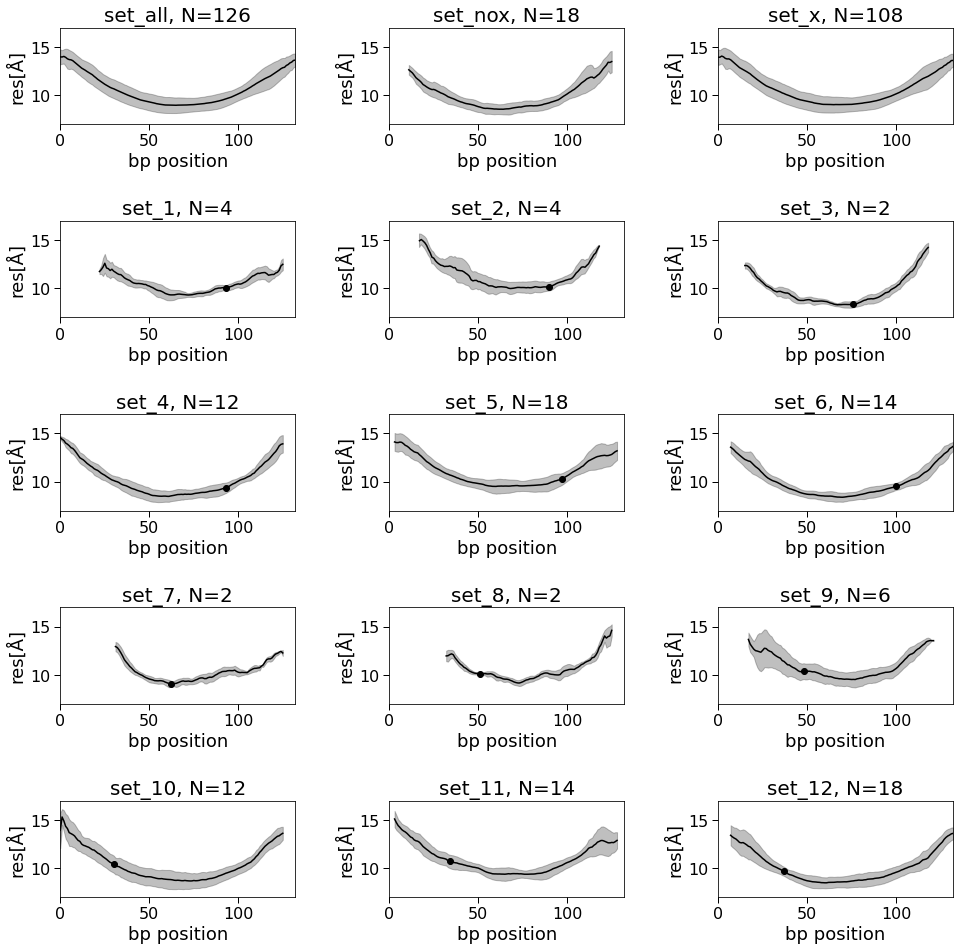

In [68]:
clear_output(wait=True)
fig,axes = plt.subplots(5,3, figsize=(16, 16),)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=1,)

plot_res_poscorr(axes = axes[0,0], set_ = set_all, show_kiss = False, color = "black", marker = 'o', label = "set_all, N={}".format(len(set_all.helices)),  showlegend = False )
plot_res_poscorr(axes = axes[0,1], set_ = set_nox, show_kiss = False, color = "black", marker = 'o', label = "set_nox, N={}".format(len(set_nox.helices)),  showlegend = False  )
plot_res_poscorr(axes = axes[0,2], set_ = set_x, show_kiss = False, color = "black", marker = 'o', label = "set_x, N={}".format(len(set_x.helices)),  showlegend = False  )

plot_res_poscorr(axes = axes[1,0], set_ = set_1, show_kiss = True, color = "black", marker = 'o', label = "set_1, N={}".format(len(set_1.helices)) ,  showlegend = False )
plot_res_poscorr(axes = axes[1,1], set_ = set_2, show_kiss = True, color = "black", marker = 'o', label = "set_2, N={}".format(len(set_2.helices)),  showlegend = False  )
plot_res_poscorr(axes = axes[1,2], set_ = set_3, show_kiss = True, color = "black", marker = 'o', label = "set_3, N={}".format(len(set_3.helices)) ,  showlegend = False )
plot_res_poscorr(axes = axes[2,0], set_ = set_4, show_kiss = True, color = "black", marker = 'o', label = "set_4, N={}".format(len(set_4.helices)) ,  showlegend = False )
plot_res_poscorr(axes = axes[2,1], set_ = set_5, show_kiss = True, color = "black", marker = 'o', label = "set_5, N={}".format(len(set_5.helices)),  showlegend = False  )
plot_res_poscorr(axes = axes[2,2], set_ = set_6, show_kiss = True, color = "black", marker = 'o', label = "set_6, N={}".format(len(set_6.helices)),  showlegend = False  )

plot_res_poscorr(axes = axes[3,0], set_ = set_7, show_kiss = True, color = "black", marker = 'o', label = "set_7, N={}".format(len(set_7.helices)),  showlegend = False  )
plot_res_poscorr(axes = axes[3,1], set_ = set_8, show_kiss = True, color = "black", marker = 'o', label = "set_8, N={}".format(len(set_8.helices)),  showlegend = False  )
plot_res_poscorr(axes = axes[3,2], set_ = set_9, show_kiss = True, color = "black", marker = 'o', label = "set_9, N={}".format(len(set_9.helices)),  showlegend = False  )
plot_res_poscorr(axes = axes[4,0], set_ = set_10, show_kiss = True, color = "black", marker = 'o', label = "set_10, N={}".format(len(set_10.helices)) ,  showlegend = False )
plot_res_poscorr(axes = axes[4,1], set_ = set_11, show_kiss = True, color = "black", marker = 'o', label = "set_11, N={}".format(len(set_11.helices)),  showlegend = False  )
plot_res_poscorr(axes = axes[4,2], set_ = set_12, show_kiss = True, color = "black", marker = 'o', label = "set_12, N={}".format(len(set_12.helices)),  showlegend = False  )

plt.savefig("/Users/fabiankohler/Desktop/126hb_zres_3columns_flat_black.pdf", format = 'pdf')